<a href="https://colab.research.google.com/github/abragroup/AI-Course-finance-demo-alibaba/blob/master/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#matrix math & data pre-processing
import numpy as np
# data formating
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/"

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("BABA", start="2017-01-01").reset_index()
df_full.to_csv('alibaba.csv',index=False)
df_full.head()

Mounted at /content/drive
/content/drive/My Drive
[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,89.000000,89.000000,88.080002,88.599998,88.599998,8789400
1,2017-01-04,88.985001,90.889999,88.580002,90.510002,90.510002,11490200
2,2017-01-05,91.910004,94.809998,91.639999,94.370003,94.370003,16821500
3,2017-01-06,94.400002,94.500000,93.000000,93.889999,93.889999,7639800
4,2017-01-09,94.160004,95.650002,93.309998,94.720001,94.720001,10829500


In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [0]:
df_full = pd.read_csv('alibaba.csv')

In [4]:
df= df_full.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals
    
    

,signal,trend,RollingMax,RollingMin
0,0.0,88.599998,NaN,NaN
1,0.0,90.510002,NaN,NaN
2,0.0,94.370003,NaN,NaN
3,0.0,93.889999,NaN,NaN
4,0.0,94.720001,NaN,NaN
5,0.0,96.750000,NaN,NaN
6,0.0,96.940002,NaN,NaN
7,0.0,95.900002,NaN,NaN
8,0.0,96.269997,NaN,NaN
9,0.0,96.120003,NaN,NaN


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 200
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest
  
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 71: cannot sell anything, inventory 0
day 74: cannot sell anything, inventory 0
day 75: cannot sell anything, inventory 0
day 76: cannot sell anything, inventory 0
day 77: cannot sell anything, inventory 0
day 80: cannot sell anything, inventory 0
day 81: cannot sell anything, inventory 0
day 82: cannot sell anything, inventory 0
day 87: cannot sell anything, inventory 0
day 89: cannot sell anything, inventory 0
day 90: cannot sell anything, inventory 0
day 91: cannot sell anything, inventory 0
day 92: cannot sell anything, inventory 0
day 96: cannot sell anything, inventory 0
day 105: cannot sell anything, inventory 0
day 107: cannot sell anything, inventory 0
day 108: cannot sell anything, inventory 0
day 117: cannot sell anything, inventory 0
day 122: cannot sell anything, inventory 0
day 126: cannot sell anything, inventory 0
day 130: cannot sell anything, inventory 0
day 131: cannot sell anything, inventory 0
day 132: cannot sell anything, inventory 0
day 133: cannot sell anyt

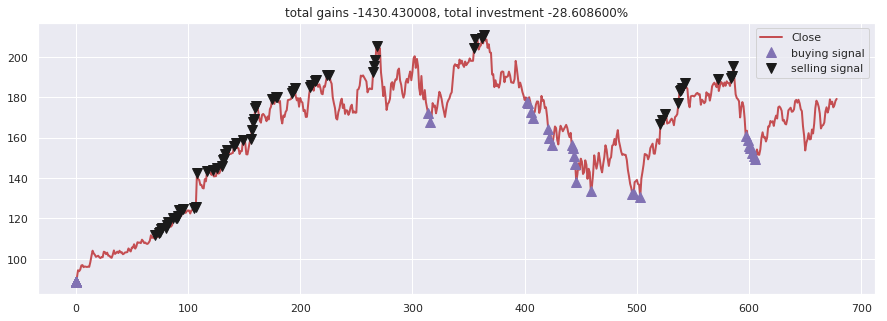

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('/'+name+'.png')
plt.show()
